In [4]:
from importlib import reload
reload(custom_dataset)
reload(diceloss)
from custom_dataset import SegmentationDataset
from diceloss import DiceLoss

In [5]:
dir_img = 'patches/train/gt/'
dir_mask = 'patches/train/mask/'
dataset = SegmentationDataset(dir_img, dir_mask, 1, 256)

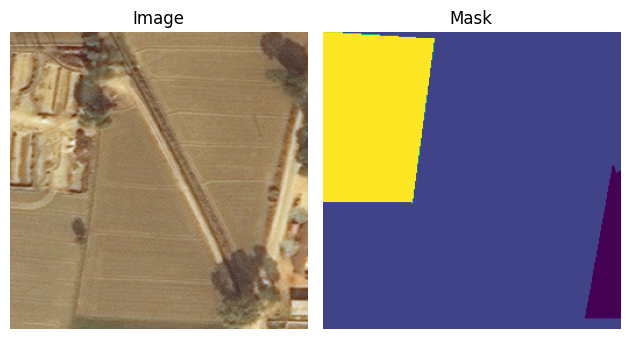

In [8]:
lookup = 2510
fig, axes = plt.subplots(1, 2)

axes[0].imshow(dataset[lookup][0].permute(1,2,0))
axes[0].set_title('Image')

# Plot the second image
axes[1].imshow(torch.argmax(dataset[lookup][1].to(torch.uint8), axis=0))
axes[1].set_title('Mask')

axes[0].axis('off')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [9]:
val_percent = 0.2
batch_size = 32
n_classes=7
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, drop_last=True)

In [10]:
net = FCN8(n_classes)
net.cuda()

summary(net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
            Conv2d-2         [-1, 64, 256, 256]          36,928
            Conv2d-3        [-1, 128, 128, 128]          73,856
            Conv2d-4        [-1, 128, 128, 128]         147,584
            Conv2d-5          [-1, 256, 64, 64]         295,168
            Conv2d-6          [-1, 256, 64, 64]         590,080
            Conv2d-7          [-1, 256, 64, 64]         590,080
            Conv2d-8          [-1, 512, 32, 32]       1,180,160
            Conv2d-9          [-1, 512, 32, 32]       2,359,808
           Conv2d-10          [-1, 512, 32, 32]       2,359,808
           Conv2d-11          [-1, 512, 16, 16]       2,359,808
           Conv2d-12          [-1, 512, 16, 16]       2,359,808
           Conv2d-13          [-1, 512, 16, 16]       2,359,808
           Conv2d-14              [-1, 

In [11]:
def classcount(loader):
    n_train = len(loader)

    class_weight = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

    with tqdm(total=n_train, desc='Class Count Assessment', unit='batch', disable = False, leave=True) as pbar:
        for X_, y_ in loader:
            imgs, true_masks = X_, torch.argmax(y_.to(torch.uint8), axis=1)
            (unique, counts) = np.unique(true_masks, return_counts=True)
            frequencies = np.asarray((unique, counts))
            for i in range(frequencies.shape[1]):
                class_weight[frequencies[0,i]] += frequencies[1,i]
            pbar.update()

    class_weight = class_weight[:-1].min()/class_weight
    class_weight[-1]=0

    return class_weight

In [12]:
def regul_term(model, lambd=0.1):
    reg = 0
    for param in model.parameters():
        reg += lambd * (param ** 2).sum()
    return reg

In [13]:
criterion = nn.MSELoss()

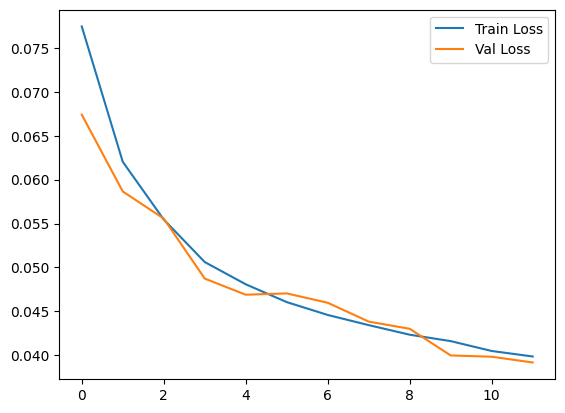

In [ ]:
train_set_len = len(train_loader)
val_set_len = len(val_loader)
train_loss, val_loss = [], []
best_accu = 1e6

lambd=0

plt.figure()

optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

epochs = 500
for epoch in tqdm(range(epochs), desc='Epoch'):
        net.train()
        
        accu = 0.0

        for X_, y_ in train_loader:
            # Use half precision model for training
             
            X_ = X_.cuda()
            y_ = y_.cuda().float()    
            
            y_hat = net(X_)

            ## Cross Entropy Loss
            loss = criterion(y_hat, y_) + regul_term(net, lambd)
            accu += loss.item()

            optimizer.zero_grad()
            loss.backward()
            #nn.utils.clip_grad_value_(net.parameters(), 0.1)
            optimizer.step()
            
        train_loss.append(accu / train_set_len)
        
        net.eval()
        accu = 0.0
        
        with torch.no_grad():
            for X_, y_ in val_loader:
                
                X_ = X_.cuda()
                y_ = y_.cuda().float()

                y_hat = net(X_)

                ## Cross Entropy Loss
                loss = criterion(y_hat, y_)+ regul_term(net, lambd)

                accu += loss.item()
                
            val_loss.append(accu / val_set_len)
            
        if accu < best_accu:
            torch.save(net.state_dict(), 'net.pt')
            best_accu = accu
            
        plt.clf()
        plt.plot(train_loss,label='Train Loss')
        plt.plot(val_loss,label='Val Loss')
        plt.legend()        
        plt.savefig('training_loss.png')
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [12]:
net.load_state_dict(torch.load('net.pt'))

<All keys matched successfully>

In [21]:
mapping = {(0  , 255, 255): 0,     #urban_land
           (255, 255, 0  ): 1,    #agriculture
           (255, 0  , 255): 2,    #rangeland
           (0  , 255, 0  ): 3,      #forest_land
           (0  , 0  , 255): 4,      #water
           (255, 255, 255): 5,     #barren_land
           (0  , 0  , 0  ): 6}           #unknown
pixel_type = ['urban_land', 'agriculture', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
class_colors = {0: 'grey', 1: 'yellow', 2: 'lawngreen', 3: 'darkgreen', 4: 'blue', 5: 'goldenrod', 6: 'red'}

In [26]:
def plot_net_output(y):
    fig, axes = plt.subplots(1, y.shape[1], figsize=(12,12))
    title_mapping = ['urban_land', 'agriculture', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
    global_min = y.min()
    global_max = y.max()
    for i in range(y.shape[1]):
        axes[i].imshow(y[0,i,...].cpu(),  vmin=global_min, vmax=global_max)
        axes[i].axis('off')
        axes[i].set_title(f'{title_mapping[i]}')
        
    plt.tight_layout()
    plt.show() 

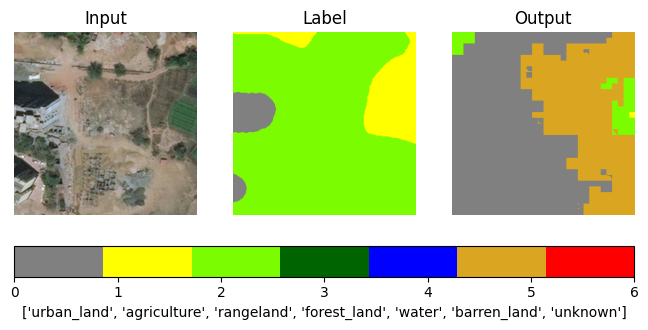

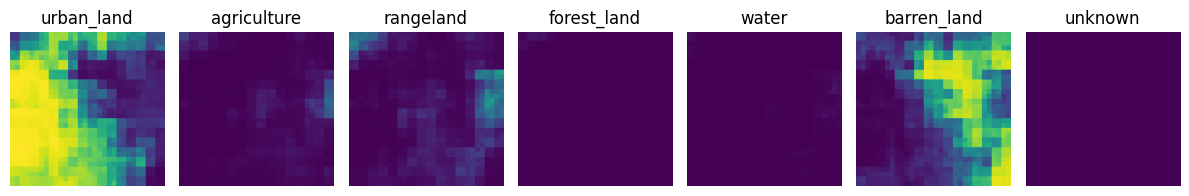

In [36]:
lookup = 1456

with torch.no_grad():
    X_, y_ = val_loader.dataset[lookup]
    X_ = X_.unsqueeze(0).cuda()
    y_ = y_.to(torch.long).unsqueeze(0).cuda()
    
    y_hat = net(X_)
    
y_ = torch.argmax(y_, axis=1).cpu().permute(1,2,0)
classes = torch.argmax(y_hat, axis=1).cpu().permute(1,2,0)

label_img = np.empty((*classes.shape[:-1], 3), dtype=int)
    
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
        label_img[i,j] = webcolors.name_to_rgb(class_colors[int(y_[i, j])])
            
output_img = np.empty((*classes.shape[:-1], 3), dtype=int)
    
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
        output_img[i,j] = webcolors.name_to_rgb(class_colors[int(classes[i, j])])
        
fig, axs = plt.subplots(1, 3, figsize=(8, 8))

axs[0].imshow(X_.squeeze(0).cpu().permute(1,2,0))
axs[0].set_title('Input')
axs[0].axis('off')

axs[1].imshow(label_img)
axs[1].set_title('Label')
axs[1].axis('off')

axs[2].imshow(output_img)
axs[2].set_title('Output')
axs[2].axis('off')

cmap = ListedColormap([class_colors[i] for i in range(len(pixel_type))])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(pixel_type) - 1))
sm.set_array([])

cb = fig.colorbar(sm, ticks=range(len(pixel_type)), orientation='horizontal', ax=axs.ravel().tolist(), anchor=(0.5, 2), label=pixel_type)

plot_net_output(y_hat)